## Creation of the MCQ-tuned model by fine-tuning the Base model with Custom MCQ dataset

---

# MCQ Custom Dataset Creation

## 1. Introduction

High-quality data is fundamental for producing a good model; the higher the quality of the data, the better the resulting model. The following steps outline the process of creating a dataset specifically for fine-tuning our Llama2 model.



![](https://i.imgur.com/IDNhAWH.png)


There are several types of datasets that can be used to fine-tune Large Language Models (LLMs):

1. **Instruction Datasets:** These datasets contain direct instructions or prompts followed by the correct or expected outputs.

2. **Raw Completion:** This involves providing a prompt to the model and letting it generate a response without any predefined correct answer.

3. **Preference Datasets:** These datasets include human feedback in the form of preferences, where annotators compare pairs of model outputs to determine which is better.

4. **Human Feedback Data:** This is specific to Reinforcement Learning from Human Feedback (RLHF) and involves direct feedback on the model's outputs from human annotators.

5. **Demonstration Data:** Also used in RLHF, these datasets consist of examples showing ideal model outputs or actions, typically created by humans.

6. **Reward Modeling Data:** Used to train a reward model in RLHF, this dataset predicts human feedback on model outputs based on actual feedback data.

7. **Dialogue Data:** Particularly relevant for conversational AI, this includes annotated conversations that indicate the quality of responses or provide corrections.


---



* Typically, an instruction dataset is utilized for fine-tuning the Llama 2 Model. Since we are focusing on Supervised Fine Tuning, the instruction dataset becomes our primary choice.

Therefore, we have 2 options:

1. Create our own Instruction Dataset.
2. Modify an existing instruction dataset, which involves filtering, modifying, and enriching it.

We have decided to proceed with the 1st option: creating our own Instruction Dataset.

* This will involve prompt engineering and incorporating sanity checks to ensure quality and relevance.

## 2. Load and analyze the dataset

In [ ]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu huggingface_hub

In [ ]:
# Import the required libraries
import json
import sys
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import faiss
from tqdm.autonotebook import tqdm
import numpy as np

In [ ]:
# Load JSON data from a file
with open("mcq_data.json", "r") as f:
    data = json.load(f)

# Create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Calculate the number of rows for each dataset split
num_rows = len(df)
train_end = int(num_rows * 0.8)  # 80% for training
test_end = train_end + int(num_rows * 0.1)  # 10% for testing

# Split the DataFrame into training, testing, and validation sets
df_train = df[:train_end]
df_test = df[train_end:test_end]
df_val = df[test_end:]  # Ensures the remainder is used for validation

# Create Datasets from the DataFrames
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
dataset_val = Dataset.from_pandas(df_val)

# Create a DatasetDict containing the split datasets
dataset = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'val': dataset_val
})

# Print the structure of the created DatasetDict
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Instruction', 'Question', 'A', 'B', 'C', 'D', 'Correct Answer', 'Explanation'],
        num_rows: 334
    })
    test: Dataset({
        features: ['Instruction', 'Question', 'A', 'B', 'C', 'D', 'Correct Answer', 'Explanation'],
        num_rows: 41
    })
    val: Dataset({
        features: ['Instruction', 'Question', 'A', 'B', 'C', 'D', 'Correct Answer', 'Explanation'],
        num_rows: 43
    })
})


In [ ]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

Instruction  \
0    Create an MCQ on the structure of artificial n...   
1    Create an MCQ on the training process of artif...   
2    Create an MCQ on the role of artificial neuron...   
3    Create an MCQ on the purpose of hidden layers ...   
4         Create an MCQ on the basics of deep learning   
..                                                 ...   
329  Create an MCQ on the hyperparameter 'Kernel' i...   
330  Create an MCQ on the hyperparameter 'Gamma' in...   
331  Create an MCQ on the hyperparameter 'learning_...   
332  Create an MCQ on the hyperparameter 'n_estimat...   
333  Create an MCQ on the application of deep learn...   

                                              Question  \
0    What is the structure of an artificial neural ...   
1    What is the purpose of the training process in...   
2    What is the role of artificial neurons in neur...   
3    What is the purpose of hidden layers in artifi...   
4                               What is deep learning?   
..                                                 ...   
329  What does the hyperparameter 'Kernel' define i...   
330  What does the hyperparameter 'Gamma' control i...   
331  What does the hyperparameter 'learning_rate' d...   
332  What does the hyperparameter 'n_estimators' de...   
333  Which of the following is an application of de...   

                                                     A  \
0    It consists of input layers and hidden layers ...   
1    To adjust the weights of the connections betwe...   
2               To receive input from external sources   
3               To receive input from external sources   
4    A branch of machine learning based on artifici...   
..                                                 ...   
329  The step size taken by the optimizer during ea...   
330  The step size taken by the optimizer during ea...   
331  The step size taken by the optimizer during ea...   
332  The step size taken by the optimizer during ea...   
333       Analyzing sensor data in autonomous vehicles   

                                                     B  \
0    It consists of input layers, hidden layers, an...   
1    To propagate input data forward through the la...   
2              To compute the weighted total of inputs   
3              To compute the weighted total of inputs   
4    A programming technique to explicitly define c...   
..                                                 ...   
329  The trade-off between the margin and the numbe...   
330  The trade-off between the margin and the numbe...   
331  The trade-off between the margin and the numbe...   
332  The trade-off between the margin and the numbe...   
333           Recognizing objects and scenes in images   

                                                     C  \
0    It consists of input layers, hidden layers, ou...   
1    To calculate the error between the output and ...   
2            To transfer information to the next layer   
3            To transfer information to the next layer   
4    A method to process large datasets using deep ...   
..                                                 ...   
329                 The similarity between data points   
330                 The similarity between data points   
331                 The similarity between data points   
332         The number of boosting trees to be trained   
333                Transcribing spoken words into text   

                                                     D Correct Answer  \
0    It consists of input layers, hidden layers, ou...              C   
1          To achieve the desired level of performance              A   
2                                     All of the above              D   
3              To process and transform the input data              D   
4    A type of data structure inspired by the human...              A   
..                                                 ...            ...   
329     The maximum depth of each tree in the e

In [ ]:
# Read as pandas DataFrame
dataset['test'].to_pandas()

Instruction  \
0   Create an MCQ on the use of deep learning in g...   
1   Create an MCQ on the use of deep learning in a...   
2   Create an MCQ on the application of deep learn...   
3   Create an MCQ on the use of deep learning in r...   
4   Create an MCQ on the structure of artificial n...   
5   Create an MCQ on the purpose of adjusting weig...   
6   Create an MCQ on the role of artificial neuron...   
7   Create an MCQ on the complexities of neural ne...   
8   Create an MCQ on the difference between machin...   
9    Create an MCQ on the definition of deep learning   
10  Create an MCQ on the key characteristic of dee...   
11  Create an MCQ on the applications of deep lear...   
12  Create an MCQ on the training requirements of ...   
13  Create an MCQ on the types of machine learning...   
14  Create an MCQ on the types of neural networks ...   
15  Create an MCQ on the applications of deep lear...   
16  Create an MCQ on the applications of deep lear...   
17  Create an MCQ on the applications of deep lear...   
18  Create an MCQ on the main types of neural netw...   
19  Create an MCQ on the definition of Artificial ...   
20  Create an MCQ on the difference between Machin...   
21  Create an MCQ on the components of Artificial ...   
22       Create an MCQ on the aim of Machine Learning   
23          Create an MCQ on the aim of Deep Learning   
24  Create an MCQ on the difference between AI, Ma...   
25  Create an MCQ on the application of AI in spee...   
26  Create an MCQ on the application of AI in pers...   
27  Create an MCQ on the application of AI in pred...   
28  Create an MCQ on the application of AI in medi...   
29  Create an MCQ on the difference between AI, ML...   
30  Create an MCQ on the responsibilities of an AI...   
31  Create an MCQ on the skills required for a Mac...   
32  Create an MCQ on the tasks of a Deep Learning ...   
33  Create an MCQ on the difference between ML and DL   
34  Create an MCQ on the advantages of Artificial ...   
35  Create an MCQ on the disadvantages of Artifici...   
36  Create an MCQ on the advantages of Biological ...   
37  Create an MCQ on the disadvantages of Biologic...   
38  Create an MCQ on the differences between Artif...   
39  Create an MCQ on hyperparameter tuning in mach...   
40  Create an MCQ on the types of hyperparameters ...   

                                             Question  \
0   What is the role of deep learning in generativ...   
1   How is deep learning used in autonomous vehicles?   
2   What is the role of deep learning in speech re...   
3   What is the application of deep learning in re...   
4   What is the structure of an artificial neural ...   
5   What is the purpose of adjusting weights in ar...   
6   What is the role of artificial neurons in neur...   
7   What determines the complexities of neural net...   
8   What is a key difference between machine learn...   
9            What is the definition of deep learning?   
10   What is the key characteristic of deep learning?   
11  Which of the following are applications of dee...   
12  What are the training requirements for deep ne...   
13  Which types of machine learning tasks can be p...   
14  Which type of neural network is specifically d...   
15  Which application of deep learning in computer...   
16  Which application of deep learning in NLP invo...   
17  Which application of deep learning in reinforc...   
18  Which of the following are the main types of n...   
19  Which of the following best defines Artificial...   
20  What is the main difference between Machine Le...   
21  Which of the following components are part of ...   
22               What is the aim of Machine Learning?   
23                  What is the aim of Deep Learning?   
24  Which of the following best describes the diff...   
25  Which of the following is an example of AI app...   
26  Which of the following is an example of AI app...   
27  Which of the following is an example of AI app.

In [ ]:
# Read as pandas DataFrame
dataset['val'].to_pandas()

Instruction  \
0   Create an MCQ on the impact of learning rate o...   
1   Create an MCQ on the impact of number of epoch...   
2   Create an MCQ on the impact of architecture on...   
3   Create an MCQ on the strategies for hyperparam...   
4       Create an MCQ on the drawback of GridSearchCV   
5   Create an MCQ on the strategy that selects val...   
6   Create an MCQ on the advantage of RandomizedSe...   
7   Create an MCQ on the strategy that treats hype...   
8    Create an MCQ on the challenges in deep learning   
9    Create an MCQ on the advantages of deep learning   
10  Create an MCQ on the disadvantages of deep lea...   
11  Create an MCQ on the challenges in interpretin...   
12  Create an MCQ on the risk of overfitting in de...   
13  Create an MCQ on the application of machine le...   
14  Create an MCQ on the use of machine learning i...   
15  Create an MCQ on the role of machine learning ...   
16  Create an MCQ on the application of machine le...   
17  Create an MCQ on the use of machine learning i...   
18  Create an MCQ on the regularization parameter ...   
19       Create an MCQ on the kernel function in SVMs   
20  Create an MCQ on the parameter that controls t...   
21  Create an MCQ on the learning rate hyperparame...   
22  Create an MCQ on the max_depth hyperparameter ...   
23  Create an MCQ on the structure of artificial n...   
24  Create an MCQ on the training process of artif...   
25  Create an MCQ on the differences between machi...   
26  Create an MCQ on the complexity of interpretin...   
27  Create an MCQ on the computing power requireme...   
28   Create an MCQ on the definition of deep learning   
29  Create an MCQ on the key characteristic of dee...   
30  Create an MCQ on the success of deep learning ...   
31  Create an MCQ on the requirements for training...   
32  Create an MCQ on the types of machine learning...   
33  Create an MCQ on the types of neural networks ...   
34  Create an MCQ on the applications of deep lear...   
35  Create an MCQ on the applications of deep lear...   
36  Create an MCQ on the applications of deep lear...   
37  Create an MCQ on the main purpose of deep lear...   
38  Create an MCQ on the definition of Artificial ...   
39  Create an MCQ on the definition of Machine Lea...   
40  Create an MCQ on the definition of Deep Learning.   
41  Create an MCQ on the relationship between Arti...   
42         Create an MCQ on the aim of Deep Learning.   

                                             Question  \
0   What impact does the learning rate hyperparame...   
1   How does the number of epochs hyperparameter a...   
2   How does the architecture of a neural network ...   
3   Which of the following strategies is considere...   
4   What is a drawback of using GridSearchCV for h...   
5   Which hyperparameter tuning strategy selects v...   
6   What is an advantage of using RandomizedSearch...   
7   Which hyperparameter tuning strategy treats th...   
8     What is one of the challenges in deep learning?   
9     What is one of the advantages of deep learning?   
10  What is one of the disadvantages of deep learn...   
11  What is one of the challenges in interpreting ...   
12  What is the risk associated with overfitting i...   
13  In which of the following applications are mac...   
14  Which of the following applications utilize ma...   
15  Which of the following applications involve th...   
16  Which of the following applications utilize ma...   
17  In which of the following applications are mac...   
18  What is the role of the regularization paramet...   
19  What is the purpose of the kernel function in ...   
20  Which parameter controls the influence of supp...   
21  What does the learning rate hyperparameter det...   
22  What does the max_depth hyperparameter determi...   
23  Which layer of an artificial neural network re...   
24  What is adjusted during the training process o...   
25  Which of the following requires a larger volum.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

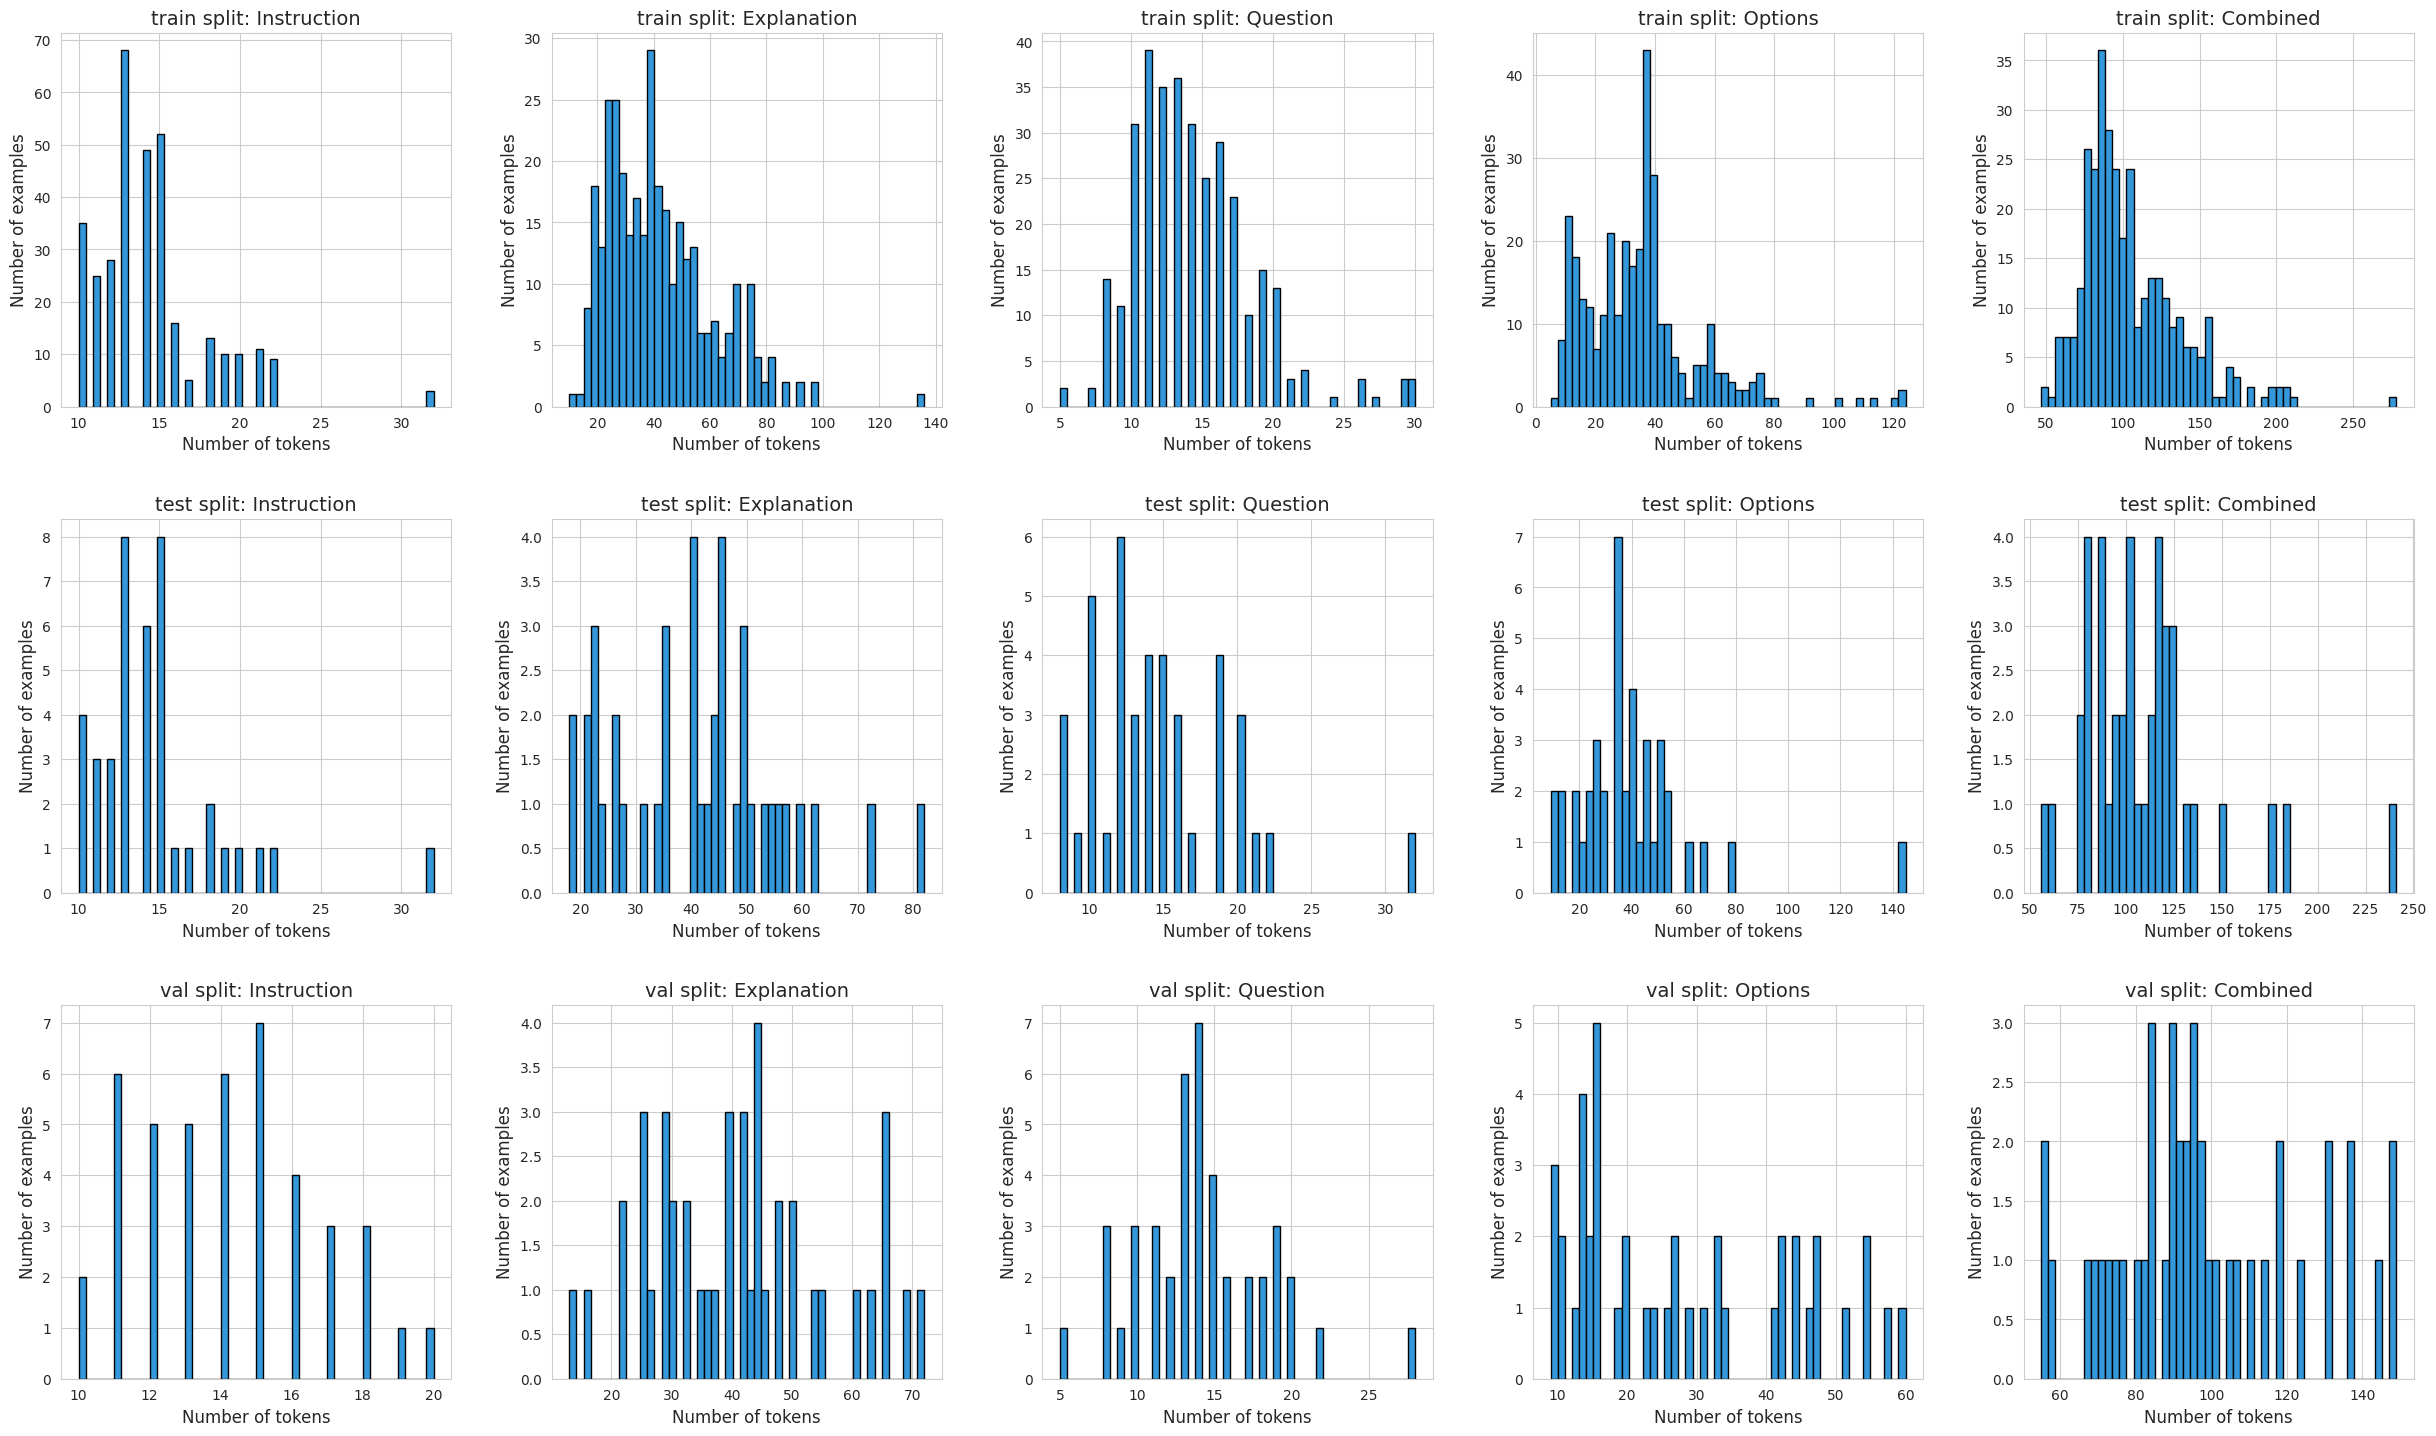

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")


def tokenize_and_count(dataset_split):
    # Tokenizing and counting tokens in the instruction field
    instruction_token_counts = [len(tokenizer.tokenize(example["Instruction"])) for example in dataset_split]

    # Tokenizing and counting tokens in the explanation field
    explanation_token_counts = [len(tokenizer.tokenize(example["Explanation"])) for example in dataset_split]

    # Tokenizing and counting tokens in the question and options fields
    question_token_counts = [len(tokenizer.tokenize(example["Question"])) for example in dataset_split]
    options_token_counts = [
        sum(len(tokenizer.tokenize(example[option])) for option in ["A", "B", "C", "D"])
        for example in dataset_split
    ]

    # Combining token counts for a comprehensive analysis
    combined_token_counts = [
        instruction + explanation + question + options
        for instruction, explanation, question, options in zip(instruction_token_counts, explanation_token_counts, question_token_counts, options_token_counts)
    ]

    return instruction_token_counts, explanation_token_counts, question_token_counts, options_token_counts, combined_token_counts


def plot_distribution(token_counts, title, ax):
    sns.set_style("whitegrid")  # Set the plot style
    ax.hist(token_counts, bins=50, color='#3498db', edgecolor='black')  # Create histogram
    ax.set_title(title, fontsize=14)  # Set title with a larger font
    ax.set_xlabel("Number of tokens", fontsize=12)  # Set x-label with a larger font
    ax.set_ylabel("Number of examples", fontsize=12)  # Set y-label with a larger font
    ax.tick_params(axis='both', which='major', labelsize=10)  # Set larger tick labels

# Create a larger figure to accommodate 5 columns and 3 rows
# Adjust figsize to ensure each subplot is large enough for clear viewing
fig, axs = plt.subplots(3, 5, figsize=(25, 15))  # Increased figure size

# Assuming 'dataset' contains your data splits
split_names = ['train', 'test', 'val']
for row, split_name in enumerate(split_names):
    # Get token counts for the current split
    instruction_counts, explanation_counts, question_counts, options_counts, combined_counts = tokenize_and_count(dataset[split_name])

    # Plotting the distributions, organizing by row based on the split
    plot_distribution(instruction_counts, f"{split_name} split: Instruction", axs[row, 0])
    plot_distribution(explanation_counts, f"{split_name} split: Explanation", axs[row, 1])
    plot_distribution(question_counts, f"{split_name} split: Question", axs[row, 2])
    plot_distribution(options_counts, f"{split_name} split: Options", axs[row, 3])
    plot_distribution(combined_counts, f"{split_name} split: Combined", axs[row, 4])

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout(pad=3.0)  # Increase padding between plots
plt.show()

## 3. Filter out rows with more than 2048 tokens

We will remove samples with more than 2048 tokens (max context size of Llama 2 by default = 4096).

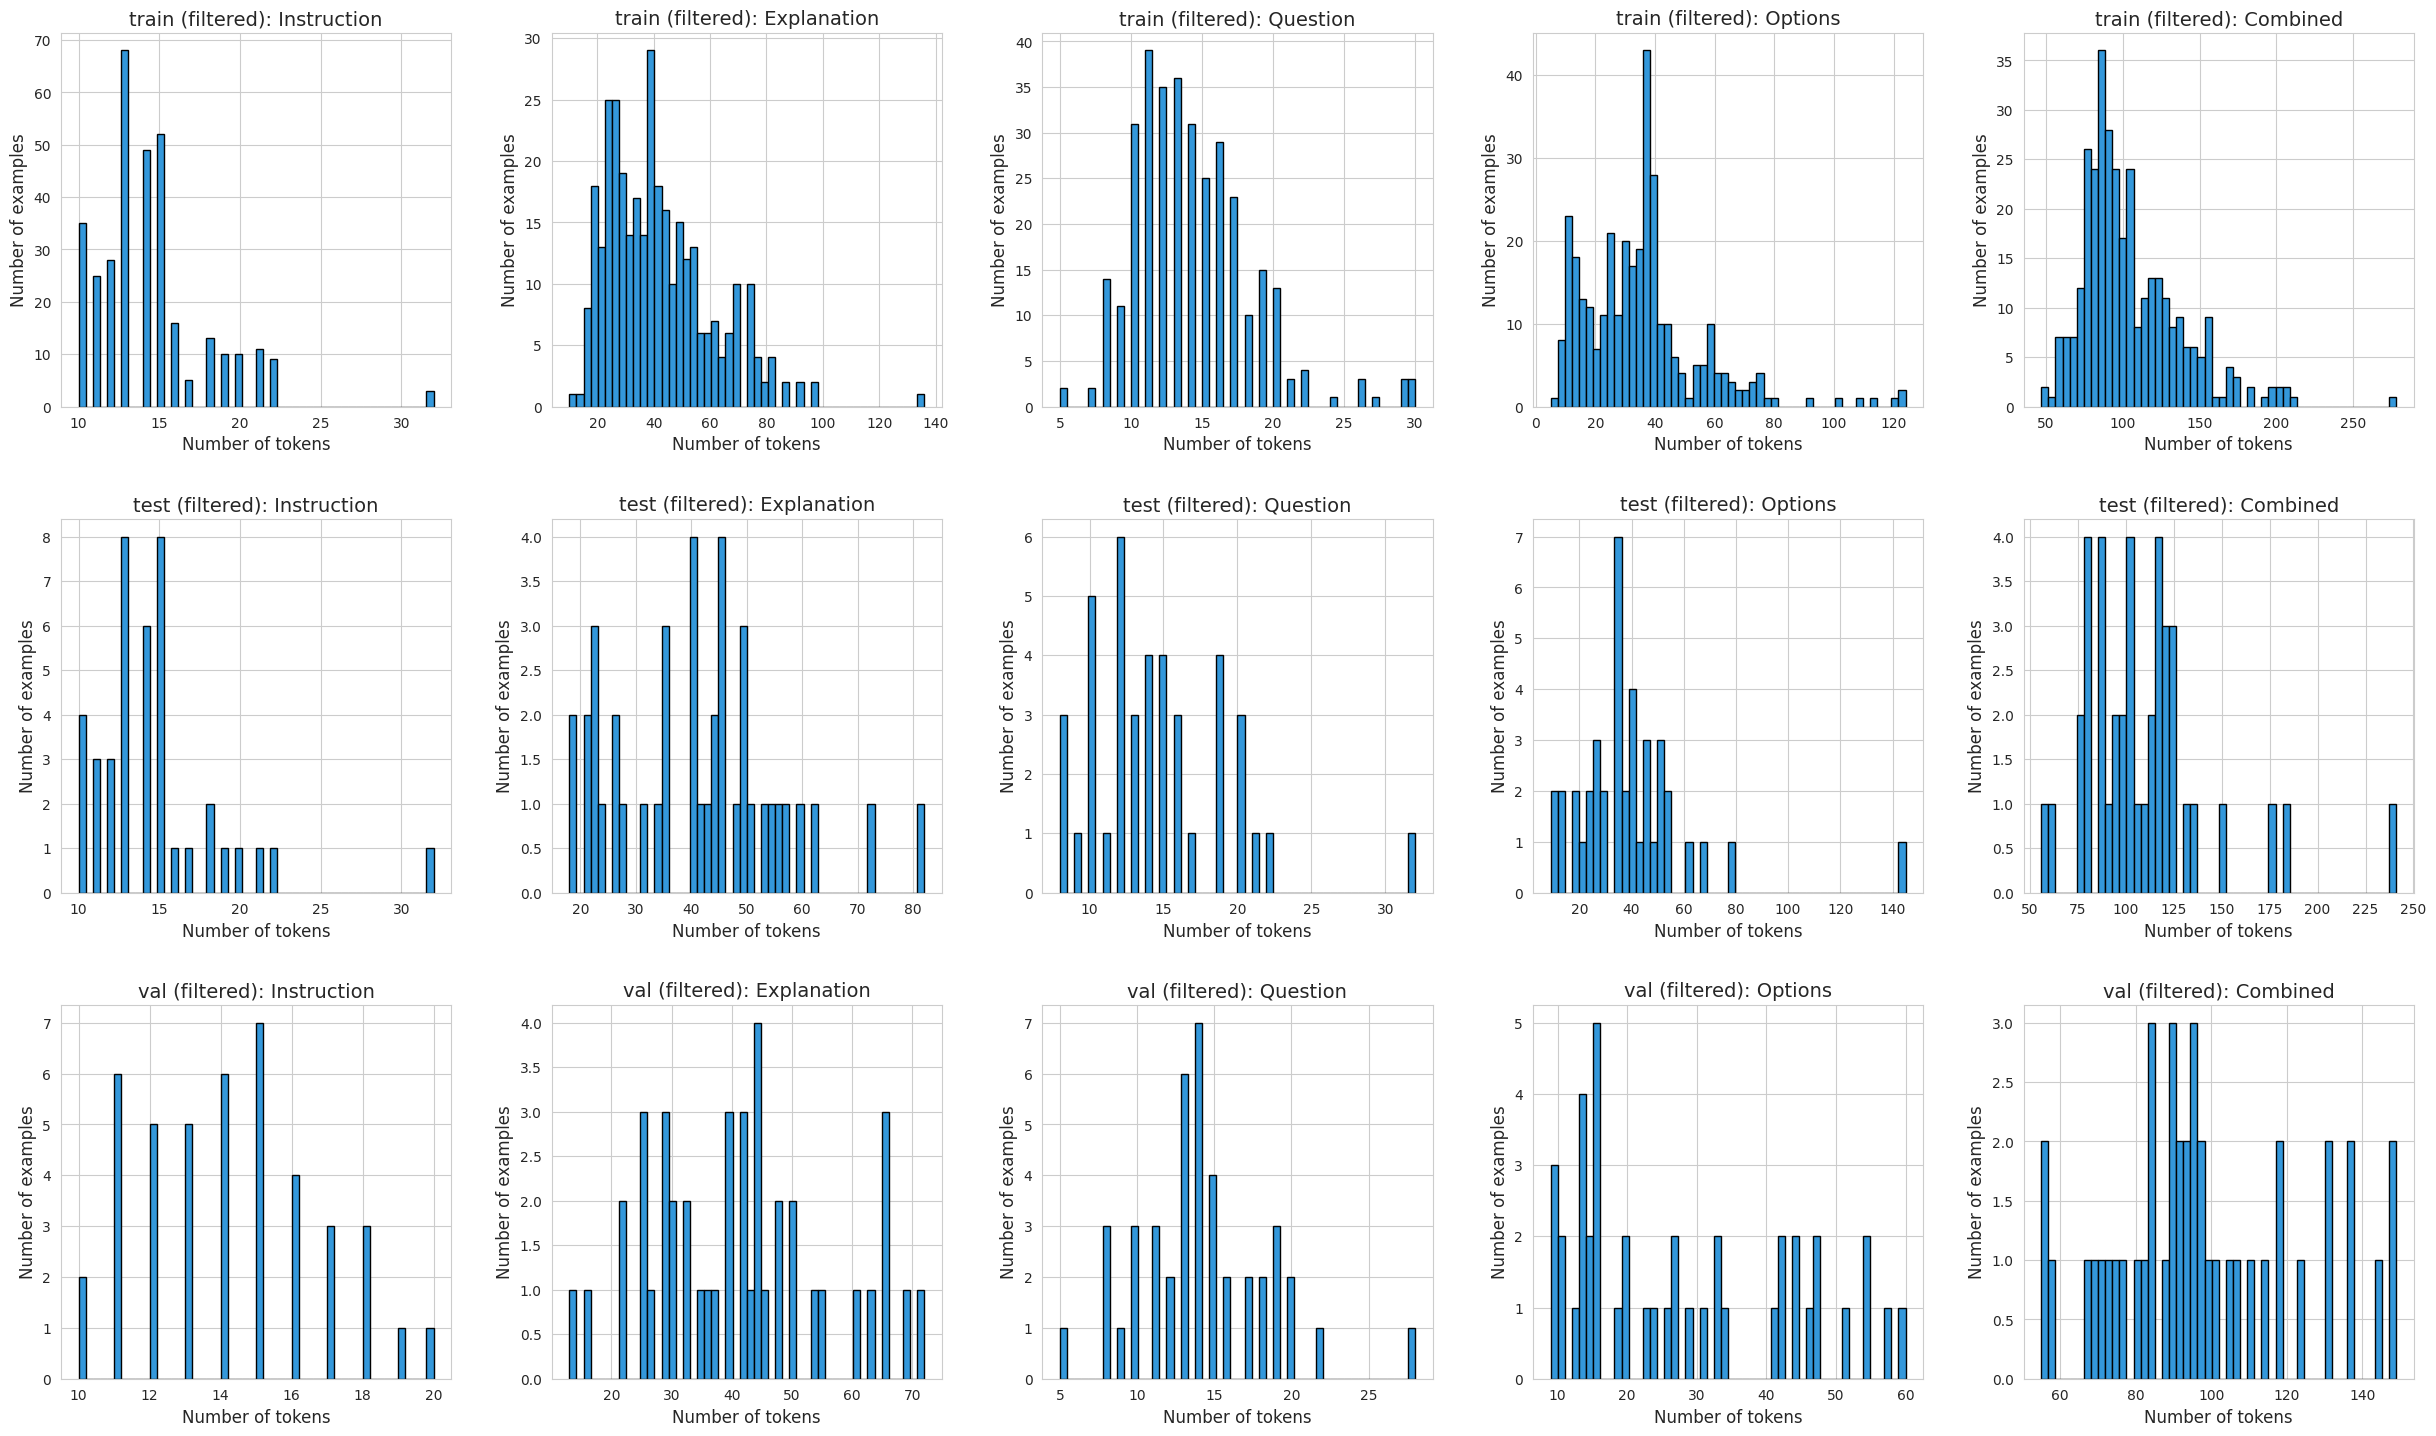

In [ ]:
def filter_by_token_count(dataset_split, combined_token_counts, max_tokens=2048):
    # Filter out rows with more than 'max_tokens' tokens
    filtered_dataset = [example for example, count in zip(dataset_split, combined_token_counts) if count <= max_tokens]
    return filtered_dataset


# Assuming 'dataset' contains your data splits
fig, axs = plt.subplots(3, 5, figsize=(25, 15))  # Adjust figure size as necessary

split_names = ['train', 'test', 'val']
for row, split_name in enumerate(split_names):
    # Tokenize and count
    instruction_counts, explanation_counts, question_counts, options_counts, combined_counts = tokenize_and_count(dataset[split_name])

    # Filter dataset based on combined token count
    filtered_dataset = filter_by_token_count(dataset[split_name], combined_counts)

    # Re-tokenize and count for the filtered dataset
    filtered_instruction_counts, filtered_explanation_counts, filtered_question_counts, filtered_options_counts, filtered_combined_counts = tokenize_and_count(filtered_dataset)

    # Plotting the distributions for the filtered datasets, organizing by row based on the split
    plot_distribution(filtered_instruction_counts, f"{split_name} (filtered): Instruction", axs[row, 0])
    plot_distribution(filtered_explanation_counts, f"{split_name} (filtered): Explanation", axs[row, 1])
    plot_distribution(filtered_question_counts, f"{split_name} (filtered): Question", axs[row, 2])
    plot_distribution(filtered_options_counts, f"{split_name} (filtered): Options", axs[row, 3])
    plot_distribution(filtered_combined_counts, f"{split_name} (filtered): Combined", axs[row, 4])

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout(pad=3.0)
plt.show()


Number of valid rows in train: 334
Removing 0 rows from train...
Number of valid rows in test: 41
Removing 0 rows from test...
Number of valid rows in val: 43
Removing 0 rows from val...


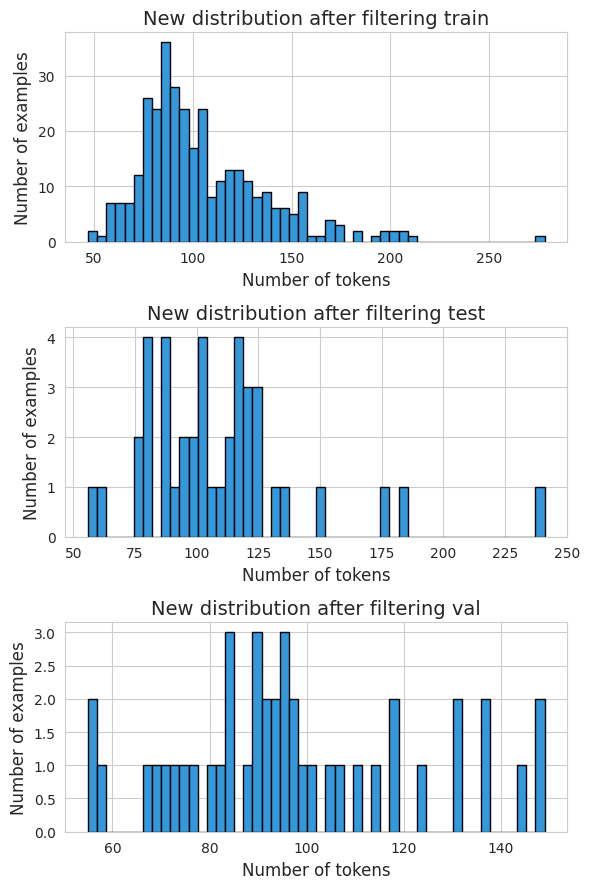

In [ ]:
# Function to filter dataset and plot new distribution
def filter_and_plot(dataset_split_name, dataset_split_data, combined_token_counts, axs, position):
    # Filter out rows with more than 2048 tokens
    valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
    print(f"Number of valid rows in {dataset_split_name}: {len(valid_indices)}")
    print(f"Removing {len(dataset_split_data) - len(valid_indices)} rows from {dataset_split_name}...")

    # Extract valid rows based on indices
    valid_dataset = [dataset_split_data[i] for i in valid_indices]

    # Re-calculate token counts for the valid dataset if necessary
    # This step is assumed necessary only if the token counts need to be recalculated for the filtered dataset
    # Otherwise, valid_token_counts = [combined_token_counts[i] for i in valid_indices] would suffice
    _, _, _, _, valid_combined_counts = tokenize_and_count(valid_dataset)

    # Plot the new distribution for valid rows
    plot_distribution(valid_combined_counts, f"New distribution after filtering {dataset_split_name}", axs[position])

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 9))  # Adjust figsize as necessary

# Assuming the 'dataset' variable is a dictionary containing data splits 'train', 'test', and 'val'
for i, split_name in enumerate(['train', 'test', 'val']):
    # Tokenize and count for the specific dataset split
    _, _, _, _, combined_counts = tokenize_and_count(dataset[split_name])

    # Filter datasets based on token count and plot the new distribution
    filter_and_plot(split_name, dataset[split_name], combined_counts, axs, i)

plt.tight_layout()
plt.show()


In [ ]:
# Initialize a flag to indicate whether any entries were removed in any split
entries_removed = False

# Iterate over each split in the dataset
for split_name in ['train', 'test', 'val']:
    # Get the original length of the split
    original_length = len(dataset[split_name])
    # Tokenize and count tokens in the split
    _, _, _, _, combined_counts = tokenize_and_count(dataset[split_name])
    # Determine valid indices (entries with <= 2048 tokens)
    valid_indices = [i for i, count in enumerate(combined_counts) if count <= 2048]
    # Check if any entries were removed
    if len(valid_indices) < original_length:
        entries_removed = True
        # Update the dataset split with filtered entries
        dataset[split_name] = dataset[split_name].select(valid_indices)

# Flag to control execution of subsequent code
continue_execution = True

if not entries_removed:
    print("No entries removed due to token count. Skipping saving.")
    continue_execution = False

# Proceed with further steps only if entries were removed
if continue_execution:
    # Save the filtered dataset to disk
    dataset.save_to_disk('new_mcq_data')
    print("Filtered dataset saved successfully.")

No entries removed due to token count. Skipping saving.


---

## 4. Near-deduplication Using Embeddings

* Near-deduplication with embeddings is a technique that employs vector representations to effectively identify and manage nearly identical data entries.

* By transforming data into these vectors (embeddings), we can quantitatively measure how similar different pieces of data are. This transformation significantly improves our ability to manage large datasets, where sorting through and removing near-duplicates manually would be impractical.

* Widely used in fields like database management, information retrieval, and machine learning, this approach is crucial for efficient data handling and analysis.

---

### We Will Not Perform Deduplication on Our MCQ Dataset.

* **Intentional Repetition for Emphasis**: In educational contexts, certain concepts may be intentionally repeated to underscore their significance. Deduplication could diminish the dataset's educational effectiveness by removing these purposeful repetitions.

* **Variations of Similar Questions**: MCQ datasets often feature questions that, while seemingly similar, include minor variations in wording, options, or context. Inadequately designed deduplication algorithms risk eliminating these nuances, thereby losing valuable elements of the dataset.

* **Difficulty in Defining "Duplicates"**: Identifying duplicates within MCQs poses a significant challenge, as questions that appear identical might differ in subtle yet crucial ways. These distinctions often represent unique learning opportunities that would be lost through deduplication.

---


## 5. Top-k sampling

Only keep the top k samples with the most tokens.

---

### Decision on "Top-k Sampling" for Our MCQ Dataset


We have decided against employing "Top-k sampling" to select only the top k samples with the most tokens in our MCQ dataset. This approach does not align with the core objectives of MCQ dataset development for several critical reasons:


**Practical Considerations**

* **Conciseness and Effectiveness**: The hallmark of high-quality MCQs lies in their conciseness and meaningfulness. Favoring question length over substance could detract from the dataset's quality, as longer questions do not necessarily equate to higher educational value. Succinct yet profound questions are typically the most beneficial and stimulating for learners.


* Given these considerations, we conclude that "Top-k sampling," which prioritizes token count, falls short of fulfilling the requirements of our MCQ dataset. The true merit of a valuable MCQ dataset resides in its diverse and balanced assortment of topics and difficulty levels, not merely in question length. This philosophy ensures our dataset remains versatile and effective across various educational and machine learning applications.
---

In [ ]:
# @title
# Push to Hugging Face Hub
dataset.push_to_hub("ssoh/mcq_dataset_2")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ssoh/mcq_dataset_2/commit/5dfc21ef82087ee0e48b519f4ff0ac38221cb1e9', commit_message='Upload dataset', commit_description='', oid='5dfc21ef82087ee0e48b519f4ff0ac38221cb1e9', pr_url=None, pr_revision=None, pr_num=None)

---

# Fine-Tuning the Llama 2 Model

Our approach employs Supervised Fine-Tuning (SFT) to optimize the Llama 2 model. Key details of this process include:

- **Supervised Fine-Tuning (SFT)**: This method involves training the model on a curated dataset comprising specific instructions paired with corresponding responses. The primary objective is to fine-tune the model's parameters, effectively reducing the discrepancy between its generated answers and the provided ground-truth responses. These ground-truth responses serve as labels, guiding the model towards more accurate and contextually appropriate outputs.


In [ ]:
# Install necessary libraries for the project: transformers, datasets, accelerate, peft, trl, bitsandbytes, wandb and optuna
!pip install -q -U transformers datasets accelerate peft trl bitsandbytes optuna wandb

In [ ]:
# Operating System and Core Machine Learning Libraries
import os
import torch, transformers


# Dataset Handling
from datasets import load_dataset

# Transformer Models and Tokenization
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,    # Configuration class for BitsAndBytes optimization
    TrainingArguments,     # Class for setting up training hyperparameters
    pipeline,               # Utility for easy model inference deployment
    EarlyStoppingCallback,
    Trainer
)

# Advanced Fine-Tuning and Optimization Techniques
from peft import get_peft_model, LoraConfig, PeftModel, prepare_model_for_kbit_training  # Classes for Parameter-efficient Fine-tuning (PEFT)
from trl import SFTTrainer  # Trainer class for Supervised Fine-Tuning (SFT) within Text Reinforcement Learning (TRL) framework

from datasets import DatasetDict

import optuna

import shutil

import warnings

# Filter out the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

from datetime import datetime

import wandb


2024-02-19 14:27:21.059687: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 14:27:21.099346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Import the notebook_login function for Hugging Face Hub authentication
from huggingface_hub import notebook_login

# Execute the function to log in to Hugging Face Hub within the notebook environment
notebook_login()

## Fine-tuning Llama 2 model

We have three options when it comes to supervised fine-tuning: full fine-tuning, LoRA, and QLoRA.

![](https://i.imgur.com/7pu5zUe.png)


* In this section, we will fine-tune a Llama 2 model, which has 7 billion parameters, on a T4 GPU using Google Colab.

* Note that a T4 GPU comes with only 16 GB of VRAM, which is just enough to store the weights of Llama 2-7b (7 billion parameters × 2 bytes per parameter = 14 GB, in FP16 format).

* Additionally, we must account for the memory overhead caused by optimizer states, gradients, and forward activations.

* To significantly reduce VRAM usage, we will fine-tune the model using 4-bit precision. This is the primary reason for choosing QLoRA in our approach.

In [ ]:
# Setup for model: Define base and new model names
base_model = "meta-llama/Llama-2-7b-chat-hf"
new_model = "llama-2-7b-mcq_2"


# Load the datasets from Hugging Face's datasets library
train_dataset = load_dataset("ssoh/mcq_dataset_2", split="train")
# test_dataset = load_dataset("ssoh/mcq_dataset", split="test")
val_dataset = load_dataset("ssoh/mcq_dataset_2", split="val")


# # Initialize the tokenizer for the base model and set up padding configurations
# tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
# tokenizer.pad_token = tokenizer.unk_token  # Use unknown token as padding token
# tokenizer.padding_side = "right"  # Set padding to the right side of sequences

tokenizer = transformers.AutoTokenizer.from_pretrained(base_model,
                                                       padding_side='right',
                                                       add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token


Generating train split:   0%|          | 0/334 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/43 [00:00<?, ? examples/s]

In [ ]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# LoRA configuration
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.15,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map={"": 0}
)

# Cast the layernorm in fp32, make output embedding layer require grads, add the upcasting of the lmhead to fp32
model = prepare_model_for_kbit_training(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [ ]:
# Initialize WandB
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: szehanz. Use `wandb login --relogin` to force relogin


True

In [ ]:
def objective(trial):

    # Define hyperparameters outside the wandb.init to use them later in the code
    learning_rate = trial.suggest_float('learning_rate', 2e-4, 5e-4, log=True)
    num_train_epochs = trial.suggest_categorical('num_train_epochs', [4, 6, 8])
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32])
    warmup_steps = trial.suggest_int('warmup_steps', 3, 5)

    wandb.init(
        project="Education-Chatbot-Optimization",
        entity="szehanz",
        group="optuna-optimization",
        job_type="hyperparameter_search",
        reinit=True,
        config={
            "learning_rate": learning_rate,
            "num_train_epochs": num_train_epochs,
            "per_device_train_batch_size": per_device_train_batch_size,
            "warmup_steps": warmup_steps
        }
    )

    # Format the current date and time
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_dir = f"train_out_dir_{current_time}"                  # Append the current date and time to the directory name

    # Create the output directory
    os.makedirs(output_dir, exist_ok=True)                        # Using exist_ok=True to avoid error if the directory already exists


    # Define TrainingArguments with the suggested hyperparameters
    training_args = TrainingArguments(
        output_dir=output_dir,                                    # Directory for saving output models and checkpoints.
        save_strategy="steps",                                    # Save model checkpoints at regular step intervals.
        save_steps=10,                                            # Save model checkpoints every 10 steps.
        learning_rate=learning_rate,                              # Initial learning rate for the optimizer.
        per_device_train_batch_size=per_device_train_batch_size,  # Batch size per device during training.
        per_device_eval_batch_size=8,                             # Batch size per device during evaluation.
        num_train_epochs=num_train_epochs,                        # Total number of training epochs.
        warmup_steps=warmup_steps,                                # Number of warmup steps for the learning rate scheduler.
        evaluation_strategy='steps',                              # Perform evaluation at regular step intervals.
        eval_steps=10,                                            # Perform evaluation every 10 steps.
        logging_steps=10,
        optim='paged_adamw_8bit',                                 # Specifies the optimizer to use.
        lr_scheduler_type='linear',                               # Type of learning rate scheduler.
        gradient_accumulation_steps=1,                            # Number of steps to accumulate gradients before performing an update.
        load_best_model_at_end=True,                              # Load the best model based on evaluation metric at the end of training.
        report_to='wandb',                                         # Disable automatic integrations with external reporting tools.
    )


    # Initialize the Trainer with early stopping callback inside the objective function
    trainer = SFTTrainer(
        model=model,                                              # Ensure a function or a mechanism to initialize your model
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        peft_config=peft_config,
        dataset_text_field="Instruction",
        tokenizer=tokenizer,
        args=training_args,
        max_seq_length=4096,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # Train the model and evaluate within the objective function
    trainer.train()
    eval_result = trainer.evaluate()

    # Log the primary metric to WandB
    wandb.log({"eval_loss": eval_result["eval_loss"]})

    # Finish the WandB run for this trial
    wandb.finish()

    # Return the metric to be optimized
    return eval_result["eval_loss"]


# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-02-19 14:28:52,200] A new study created in memory with name: no-name-e94a85d7-d634-4ad2-8787-050a979e0a8f


Map:   0%|          | 0/334 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


[I 2024-02-19 14:40:09,515] Trial 0 finished with value: 0.8888720870018005 and parameters: {'learning_rate': 0.00022063199006940203, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 3}. Best is trial 0 with value: 0.8888720870018005.


Map:   0%|          | 0/334 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

[I 2024-02-19 14:51:33,062] Trial 1 finished with value: 0.8397907614707947 and parameters: {'learning_rate': 0.000388078354781562, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 5}. Best is trial 1 with value: 0.8397907614707947.


[I 2024-02-19 15:03:40,491] Trial 2 finished with value: 0.8322736024856567 and parameters: {'learning_rate': 0.00038013816677024434, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'warmup_steps': 4}. Best is trial 2 with value: 0.8322736024856567.


[I 2024-02-19 15:12:11,748] Trial 3 finished with value: 0.8614340424537659 and parameters: {'learning_rate': 0.00023956952379873406, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 5}. Best is trial 2 with value: 0.8322736024856567.


[I 2024-02-19 15:23:34,430] Trial 4 finished with value: 0.8308054208755493 and parameters: {'learning_rate': 0.00041915607985727055, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 3}. Best is trial 4 with value: 0.8308054208755493.


[I 2024-02-19 15:31:13,768] Trial 5 finished with value: 0.855594277381897 and parameters: {'learning_rate': 0.0004882684074952214, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 3}. Best is trial 4 with value: 0.8308054208755493.


[I 2024-02-19 15:42:35,259] Trial 6 finished with value: 0.8365665674209595 and parameters: {'learning_rate': 0.000371977101120841, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 4}. Best is trial 4 with value: 0.8308054208755493.


[I 2024-02-19 15:50:14,768] Trial 7 finished with value: 1.0364350080490112 and parameters: {'learning_rate': 0.00021352963324526537, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 5}. Best is trial 4 with value: 0.8308054208755493.


[I 2024-02-19 16:02:22,467] Trial 8 finished with value: 0.8303791284561157 and parameters: {'learning_rate': 0.0003782307395143863, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'warmup_steps': 3}. Best is trial 8 with value: 0.8303791284561157.


[I 2024-02-19 16:16:28,206] Trial 9 finished with value: 0.8504351377487183 and parameters: {'learning_rate': 0.000457264058410859, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'warmup_steps': 5}. Best is trial 8 with value: 0.8303791284561157.


In [ ]:
# Best trial results
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.8303791284561157
  Params: 
    learning_rate: 0.0003782307395143863
    num_train_epochs: 6
    per_device_train_batch_size: 16
    warmup_steps: 3


In [ ]:
# Use best hyperparameters from the study
best_trial = study.best_trial

best_learning_rate = best_trial.params['learning_rate']
best_num_train_epochs = best_trial.params['num_train_epochs']
best_per_device_train_batch_size = best_trial.params['per_device_train_batch_size']
best_warmup_steps = best_trial.params['warmup_steps']


# Define TrainingArguments with the best hyperparameters for retraining
best_training_args = TrainingArguments(
    output_dir="best_train_out_dir",
    save_strategy="steps",
    save_steps=10,
    learning_rate=best_learning_rate,
    per_device_train_batch_size=best_per_device_train_batch_size,
    per_device_eval_batch_size=8,
    num_train_epochs=best_num_train_epochs,
    warmup_steps=best_warmup_steps,
    evaluation_strategy='steps',
    eval_steps=10,
    logging_steps=10,
    optim='paged_adamw_8bit',
    lr_scheduler_type='linear',
    gradient_accumulation_steps=1,
    load_best_model_at_end=True,
    report_to='wandb',
)

# Reinitialize the Trainer with the best hyperparameters
best_trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    dataset_text_field="Instruction",
    tokenizer=tokenizer,
    args=best_training_args,
    max_seq_length=4096,
)

# Retrain the model with the best hyperparameters
best_trainer.train()


# Save trained model
best_trainer.model.save_pretrained(new_model)

# Finish the WandB run for this trial
wandb.finish()

Merging the base model with the trained adapter.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    # device_map={"": 0},
)
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()


# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Push the model and tokenizer to the Hugging Face Hub.

In [ ]:
model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ssoh/llama-2-7b-mcq_2/commit/15e8c4001435adf13ca05fb2511801305715e372', commit_message='Upload tokenizer', commit_description='', oid='15e8c4001435adf13ca05fb2511801305715e372', pr_url=None, pr_revision=None, pr_num=None)

---